# <span style='color:red'>Project 2</span>

### In this project we develop a first-order algorithm to construct a portfolio using intraday data.

In [23]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math

##### We will have data involving $n$ assets, and use the first $T$ days of the data to compute the portfolio.
##### The computation will produce a weight $x_i$ for each asset $i = 1,...,n$, which could be long or short.
##### We assume that on each day, a position is taken at the open, and closed at noon.  So we define:
$$ p^o_{j,t} = \ \text{price of asset $j$ on day $t$ at the open}$$
$$ p^1_{j,t} = \ \text{price of asset $j$ on day $t$ at noon}$$
$$ r_{j,t} =  \ \frac{p^1_{j,t} - p^o_{j,t}}{p^o_{j,t}} = \ \text{return earned by asset $j$ on day $t$.}$$
$$ \bar r_j = \ \frac{1}{T} \sum_{t = 1}^T r_{j,t} = \ \text{average return earned by asset $j$.}$$

#### The optimization problem to solve depends on two parameters: $\theta \ge 0$ and $\pi > 0 0$.
####
$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)^{1/\pi}$$
#### 
#### There are no constraints on the quantities $x_j$.
#### The first sum is minus the average return earned by the portfolio.  In the second sum, the quantity inside the square brackets is the excess return earned by the portfolio on day $t$, magnified by the power $\pi$.  The quantity $\theta$ is a risk aversion parameter.
 

### <span style='color:red'> Task 1. Develop a first-order method to address this computational problem.</span>
#### 
#### Your method should work with values of $T$ at least $100$. Use the data we provide for AMZN, NFLX, TSLA, i.e., $n = 3$. 
###
#### Make sure your code works with $\pi = 0.5, 2, 4, 6$, and $\theta = 0.1, 10, 1000, 10^5, 10^6$.

Denote the objective function as  $F(x)$. We will take the gradient of $ F(x) $ with respect to the vector $ x $. The gradient will be a vector of partial derivatives, where each element $ k $ is the partial derivative of $ F(x) $ with respect to $ x_k $.

$$ F(x) = \left(-\sum_{j = 1}^n \bar r_j x_j\right) + \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)^{1/\pi} $$

Let's take the derivative piece by piece.

1. **Derivative of the first term (g)**:
$$ \frac{dg}{dx_k} \left(-\sum_{j = 1}^n \bar r_j x_j\right) = -\bar r_k $$

2. **Derivative of the second term (h)**:
$$ \frac{dh}{dx_k} = \theta \cdot \frac{1}{\pi} \left[\frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right]^{(1/\pi)-1} \cdot \frac{1}{T} \sum_{t = 1}^{T} \pi \left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^{\pi-1} \cdot (r_{k,t} -  \bar r_k) $$

3. **Sum and simplification of the derivatives**:

$$ \frac{\partial F(x)}{\partial x_k} = -\bar r_k + \theta \cdot \left[\frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right]^{(1/\pi)-1} \cdot \frac{1}{T} \sum_{t = 1}^{T} \left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^{\pi-1} \cdot (r_{k,t} -  \bar r_k) $$

In [2]:
def func(x, r_bar, r_diff, theta, pi, T):
    return -np.dot(r_bar, x) + (theta*(1/T)**(1/pi)) * ( np.linalg.norm(r_diff @ x, pi) )

def grad(x, r_bar, r_diff, theta, pi, T):
    r_diff_at_x = r_diff @ x
    temp = (theta*(1/T)**(1/pi - 1)) * np.linalg.norm(r_diff_at_x, pi)**(1-pi) * (1/T)*( (r_diff_at_x**(pi-1)).T @ r_diff )
    return -r_bar + temp

In [3]:
df = list()
for ticker in ['AMZN', 'NFLX', 'TSLA']:
    df.append( pd.read_csv(f'./data/{ticker}_processed.csv', index_col=0) )

df = pd.concat(df, axis=1).dropna(how='any')

train = df[:100]
test = df[100:]

r_bar = train.mean(axis=0).values
r_diff = train.subtract(r_bar).values

In [4]:
def gradient_descent(r_bar, r_diff, theta, pi, x_0, alpha, beta, max_iter=1000, tolerance=1e-8):
    converged = False
    T = r_diff.shape[0]
    x = y = x_0
    f = func(x=x, r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, T=T)
    hist = [f]
    
    for _ in range(max_iter):
        # computing gradient
        grad_ = grad(x=x, r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, T=T)
        # norming gradient
        grad_ /= np.linalg.norm(grad_)
        # computing next step using momentum
        y = beta*y + (1-beta)*grad_
        x = x - alpha*y
        # evaluating new function value
        f_new = func(x=x, r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, T=T)
        hist.append(f_new)
        # checking convergence
        if f - f_new < tolerance:
            converged = True
            break
        # new function value is the old function value in the next iteration
        f = f_new
        
    return converged, x, hist

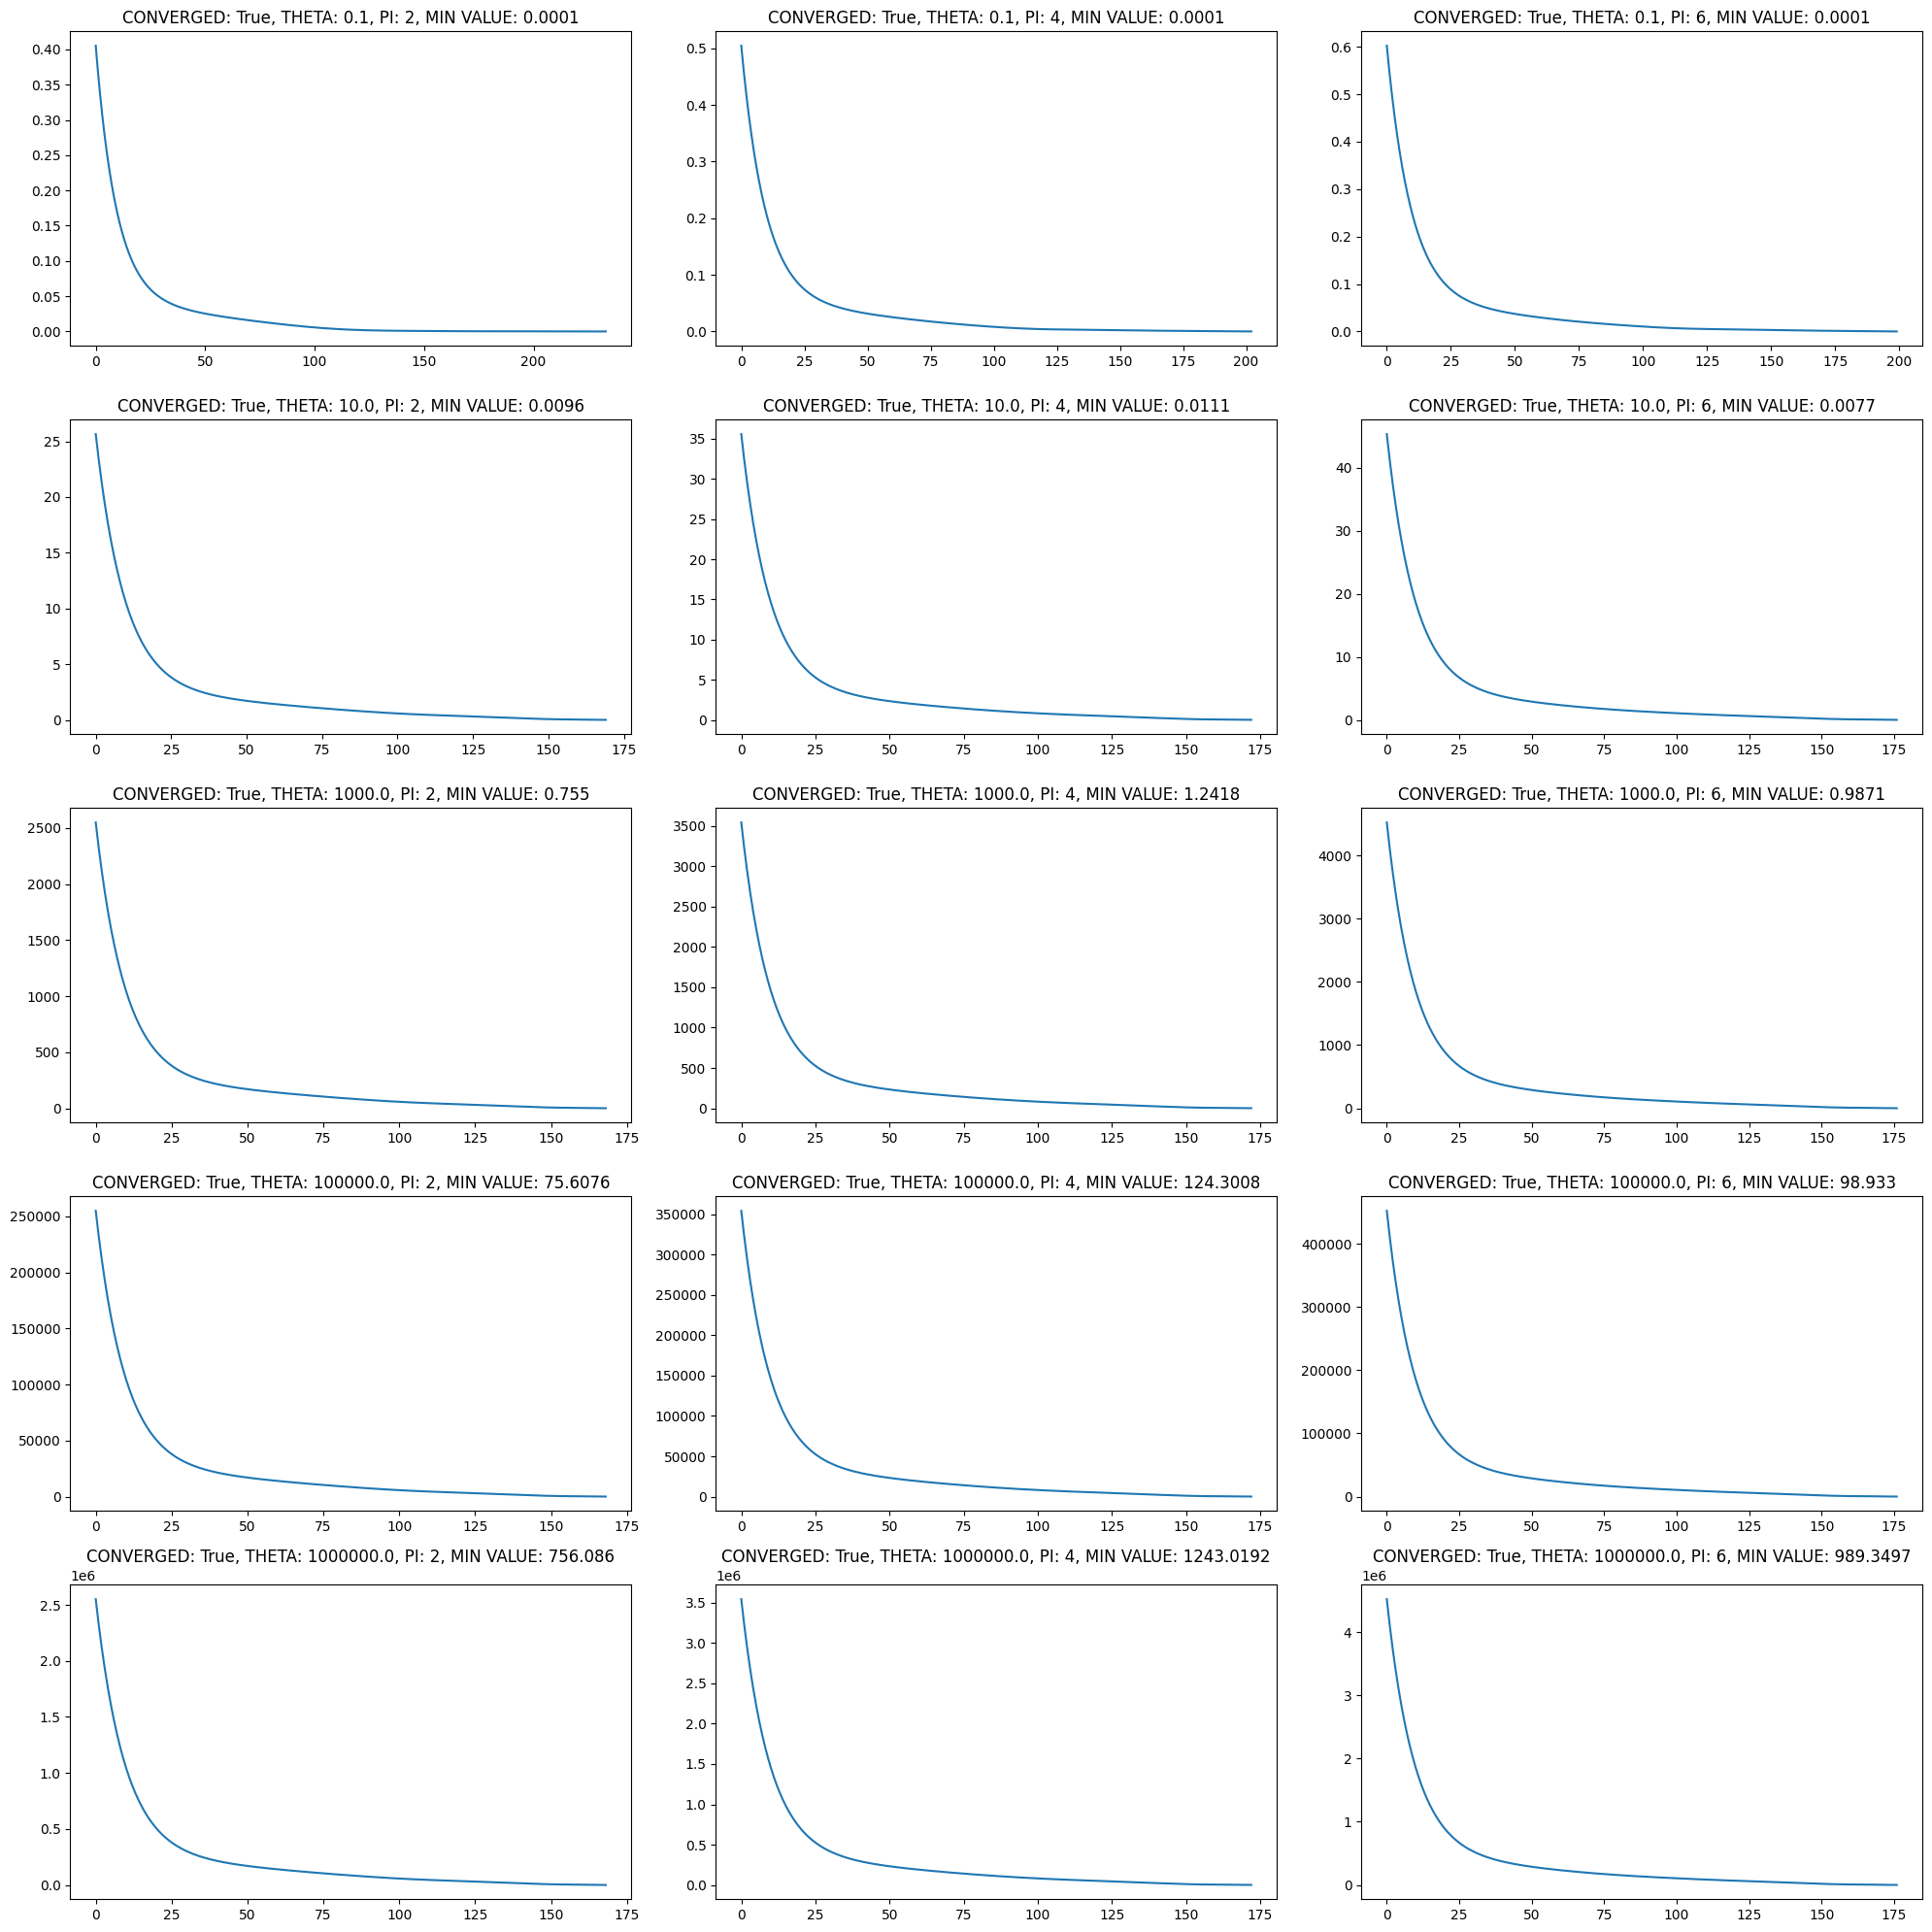

In [33]:
params = dict(
    x_0=np.array([69]*3),
    alpha=1e-1, beta=0.9,
    max_iter=500, tolerance=1e-8
)

data = dict()
for theta, pi in itertools.product([1e-1, 1e1, 1e3, 1e5, 1e6], [2, 4, 6]): # not using pi=0.5 as a possibility right now!
    data[ (theta, pi) ] = gradient_descent(r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, **params)

ncol = 3
nrow = math.ceil(len(data) / ncol)
figure, axes = plt.subplots(nrow, ncol, figsize=(20, 20))

for ax, ((theta, pi), (converged, x, hist)) in itertools.zip_longest(axes.flat, data.items()):
    if ax is not None:
        ax.set_title(f"CONVERGED: {converged}, THETA: {theta}, PI: {pi}, MIN VALUE: {round(hist[-1], 4)}")
    
        sns.lineplot(data=hist, ax=ax)
    
    else:
        figure.delaxes(ax)

plt.tight_layout()
plt.show()

### <span style='color:red'>Task 2: Benchmark your portfolio on the remaining days</span>
#### On each of the remaining days, we proceed as follows.  Denote by $x^*$ your portfolio. At the market open we invest $10^9 x^*_j$ on each asset $j$, and we close the position (by) noon.  You need to use the asset's price to compute the number of shares that you invest in, whether long or short. So the total you invest equals $$ \sum_{j = 1}^n 10^9 |x^*_j|.$$
#### Report the average return earned by your portfolio.

In [37]:
# using optimal portfolio for pi=2 and theta=1e1
x_test = data[ (1e1, 2) ][1]

(test @ x_test).mean()

-0.00025571840226391076